<h1>ECE521 Assignment 1</h1>

In [125]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [153]:
# generate data
np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
+ 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

Populating the interactive namespace from numpy and matplotlib


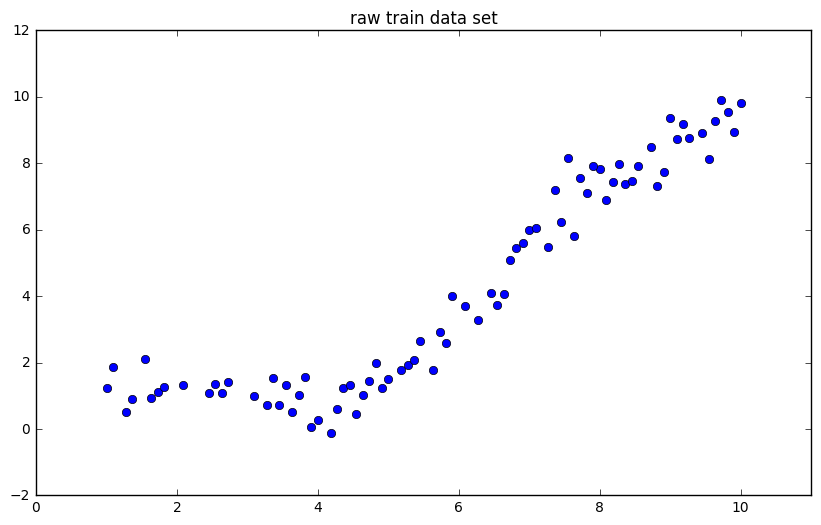

In [154]:
#plot of trainData
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

plt.plot(trainData, trainTarget, 'bo')
plt.axis([0,11, -2, 12])
plt.title("raw train data set")
plt.show()

<h1> Problem 1.2.2 Pairwise distances </h1>

In [128]:
def pairwise_dist(x, z):
    z = tf.transpose(z)
    return tf.squared_difference(x, z)

In [129]:
#testing pairwise_dist function
x = tf.constant([[1],[2],[3],[4]])
z = tf.constant([[1],[2],[3]])
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
print(sess.run(pairwise_dist(x,z)))

[[0 1 4]
 [1 0 1]
 [4 1 0]
 [9 4 1]]


<h1> Problem 1.3.1 Calculate responsibility matrix given pairwise distance matrix </h1>

In [130]:
def get_respon_mat(m, k):
    #m = tf.transpose(m)
    # get sorted index
    values, indices = tf.nn.top_k(-m, k, sorted=True)
    #indices, dummy = tf.nn.top_k(-indices, k, sorted=True)
    #indices = -indices
    # build up [[1,2], [1,3]] index form
    indices_pair = tf.tile(tf.reshape(tf.range(0, tf.shape(m)[0]), [-1,1]), [1,k])
    concated = tf.concat(2, [tf.reshape(indices_pair, [-1,k,1]), tf.reshape(indices, [-1,k,1])])
    concated = tf.reshape(concated, [-1,2])
    # return dense matrix
    value = 1 / k
    res = tf.sparse_to_dense(sparse_indices=concated, output_shape=[tf.shape(m)[0], tf.shape(m)[1]], \
                               sparse_values=value, validate_indices=False)
    return res

In [131]:
# testing for get_respon_mat function
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
r = get_respon_mat(pairwise_dist(X, train), 2)
y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
sess.run(init)
predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})

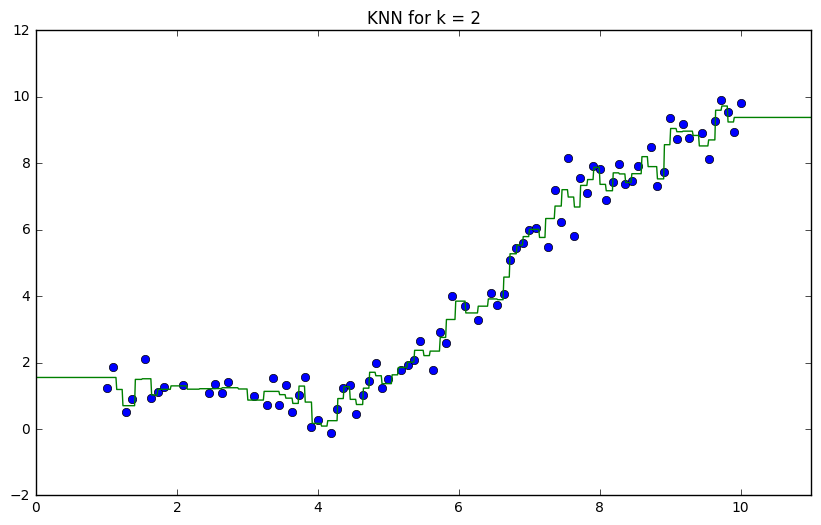

In [132]:
plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(predict), 'g-')
plt.axis([0,11, -2, 12])
plt.title("KNN for k = 2")
plt.show()

<h1> Problem 1.3.3 Prediction </h1>

k:  1, trainMSE: 0.00, validMSE: 5.43, testMSE: 6.22


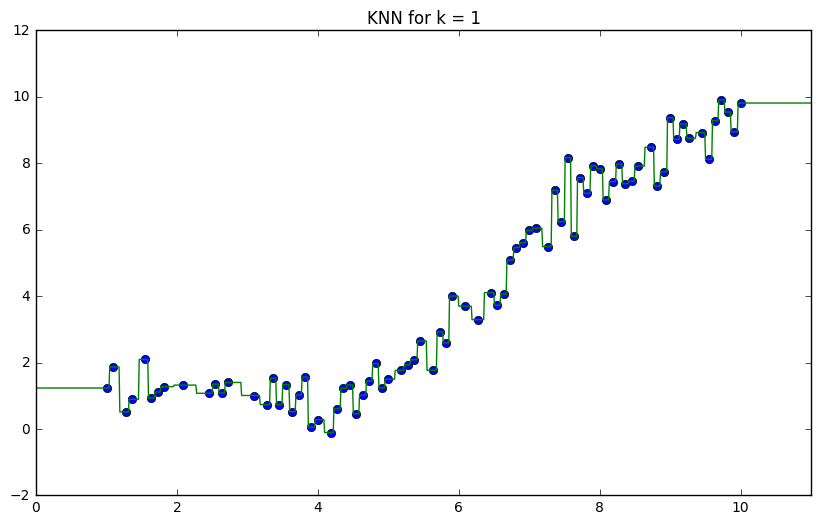

k:  3, trainMSE: 16.84, validMSE: 6.53, testMSE: 2.90


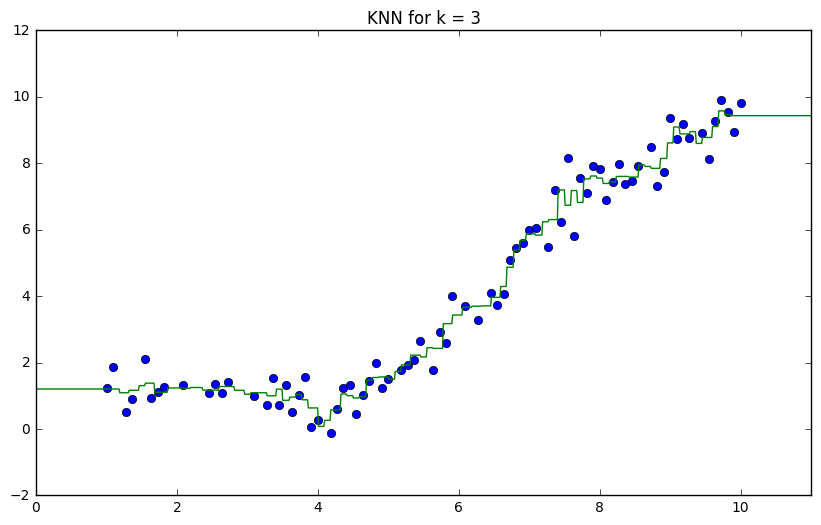

k:  5, trainMSE: 18.97, validMSE: 6.21, testMSE: 3.57


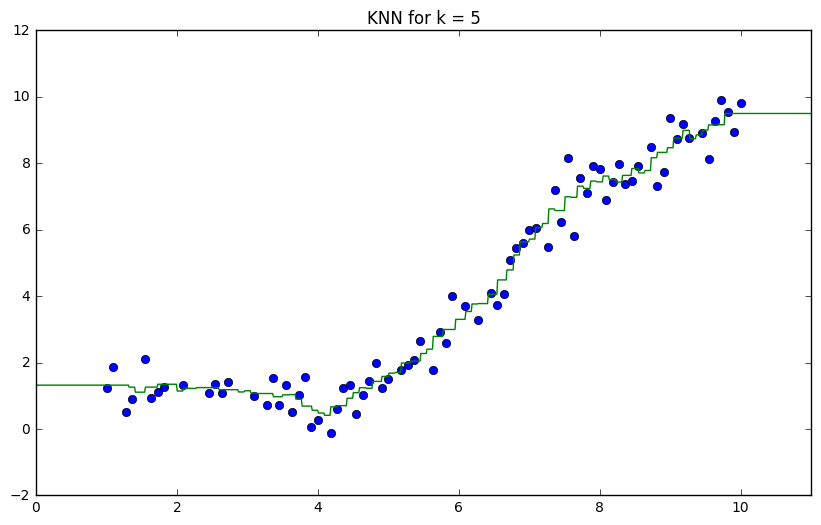

k: 50, trainMSE: 199.68, validMSE: 24.57, testMSE: 14.14


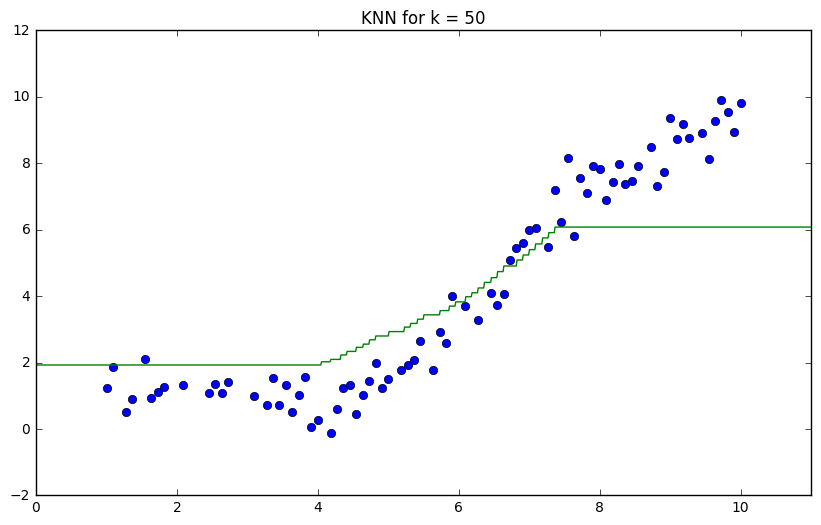

Best k value based on validation err is: 1


In [155]:
# train model
kList = [1,3,5,50]
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
plot_input = tf.constant(test_input)
best_k = 0
min_err = float("inf")
sess.run(init)
for k in kList:
    # Error definition
    r = get_respon_mat(pairwise_dist(X, train), k)
    y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
    meanSquaredError = tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - tf.transpose(Y)), reduction_indices=[1]))
    trainMSE = sess.run(meanSquaredError, feed_dict={X: trainData, Y: trainTarget, train: trainData, target: trainTarget})
    validMSE = sess.run(meanSquaredError, feed_dict={X: validData, Y: validTarget, train: trainData, target: trainTarget})
    testMSE = sess.run(meanSquaredError, feed_dict={X: testData, Y: testTarget, train: trainData, target: trainTarget})
    plot_predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})
    if validMSE < min_err:
        min_err = validMSE
        best_k = k
    print("k: %2d, trainMSE: %0.2f, validMSE: %0.2f, testMSE: %0.2f"%(k, trainMSE, validMSE, testMSE))
    plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(plot_predict), 'g-')
    plt.axis([0,11, -2, 12])
    plt.title("KNN for k = %d"%(k))
    plt.show()
print("Best k value based on validation err is: %d"%(best_k))

<h2>Conclusion</h2>
<p>From the calculation, we find the best k value based on validation error is k = 1. From the ploting, k = 1 fits every training points perfectly, but it is overfitting. For k = 3, it is more smooth, but still a little bit overfitting. For k = 50, the prediction has a great offset comparing to the training points. We think k = 5 is a better choice because it is more general and smooth.</p>

<h1>Problem 2.2 Stochastic gradient descent</h1>

In [158]:
with np.load ("../data/tinymnist.npz") as data :
        trainData, trainTarget = data ["x"], data["y"]
        validData, validTarget = data ["x_valid"], data ["y_valid"]
        testData, testTarget = data ["x_test"], data ["y_test"]

In [157]:
def buildGraph(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[64,1], stddev=0.5), name='weights')
    b = tf.Variable(0.0, name='biases')
    X = tf.placeholder(tf.float32, [None, 64], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error =  0.5 * tf.reduce_mean(tf.reduce_sum(tf.square(y_predicted - y_target), 
                                                reduction_indices=1, 
                                                name='squared_error'), 
                                  name='mean_squared_error') + \
             0.5 * decay_rate * tf.reduce_sum(tf.square(W))

    # Training mechanism
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train

def getRandomBatch(trainData, trainTarget, size):
    idx = np.random.choice(trainData.shape[0], size, replace=False)
    return trainData[idx,:], trainTarget[idx,:]

<h2>Problem 2.2.1 Tuning the learning rate</h2>

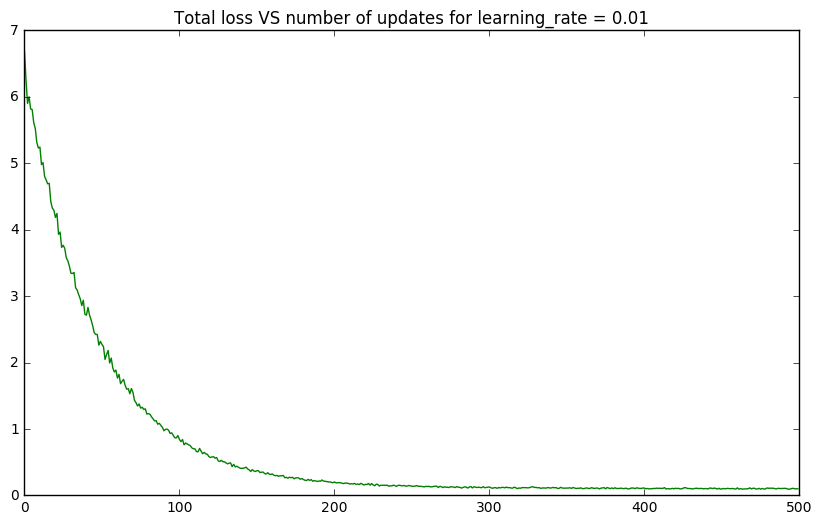

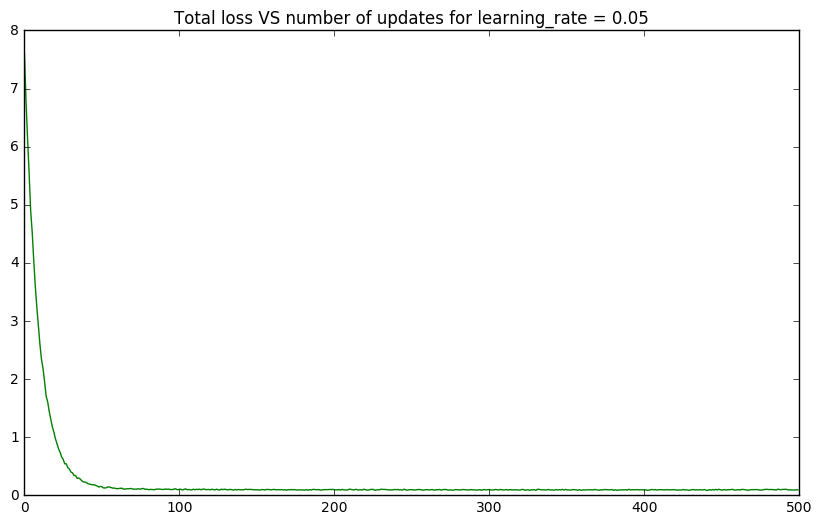

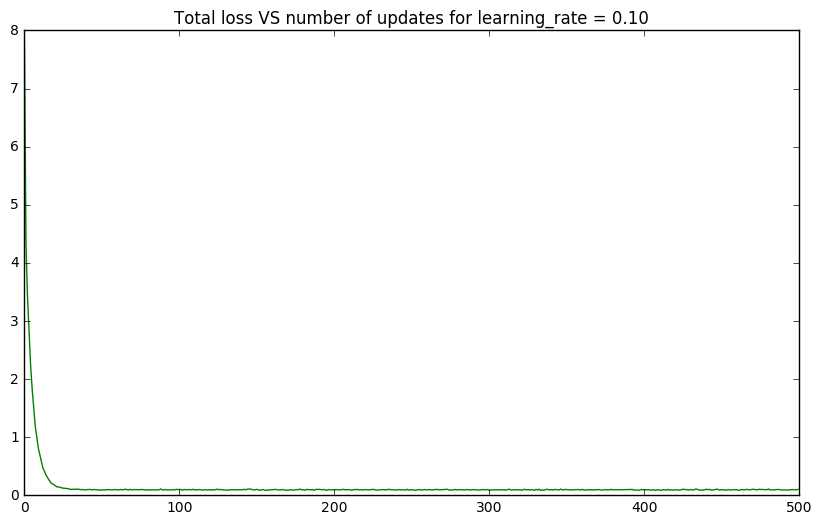

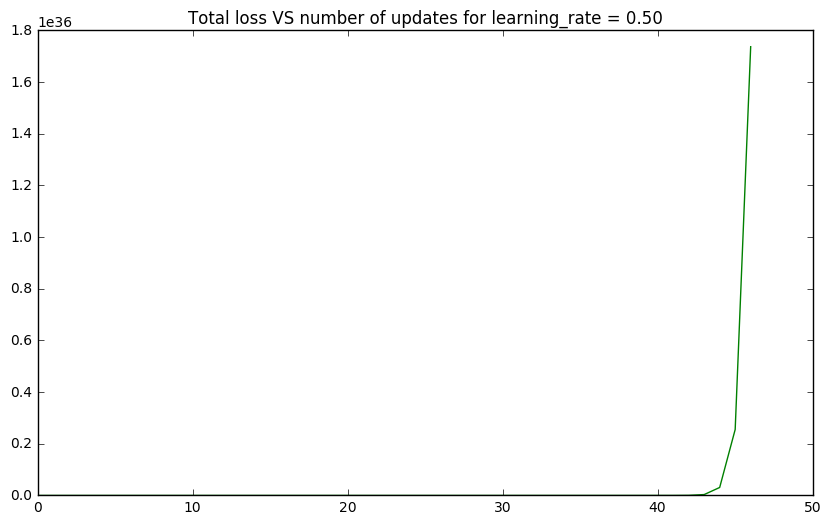

In [137]:
#2.1 fix decay_rate = 1 and tune learning_rate
decay_rate = 1
batch_size = 50
learning_rate_list = [0.01, 0.05, 0.1, 0.5]
for learning_rate in learning_rate_list: 
    W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    for itr in range(500):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        loss, _ = sess.run([error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
    plt.plot(np.arange(500), loss_recorder, 'g')
    #plt.axis([0,2000, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.2f"%(learning_rate))
    plt.show()
        

<h2>Conclusion</h2>
<p>In this problem, we fix batch size to be 50 and decay rate to be 1 and try different learning rate 0.01, 0.05, 0.1, 0.5. From the plot we can see increase learning rate will speed up convergence rate, and we obtain the best learning rate 0.1. However, as learning rate increases, it might diverge like the case of learning rate 0.5.</p>

<h2>Problem 2.2.2 Effect of the mini-batch size</h2>

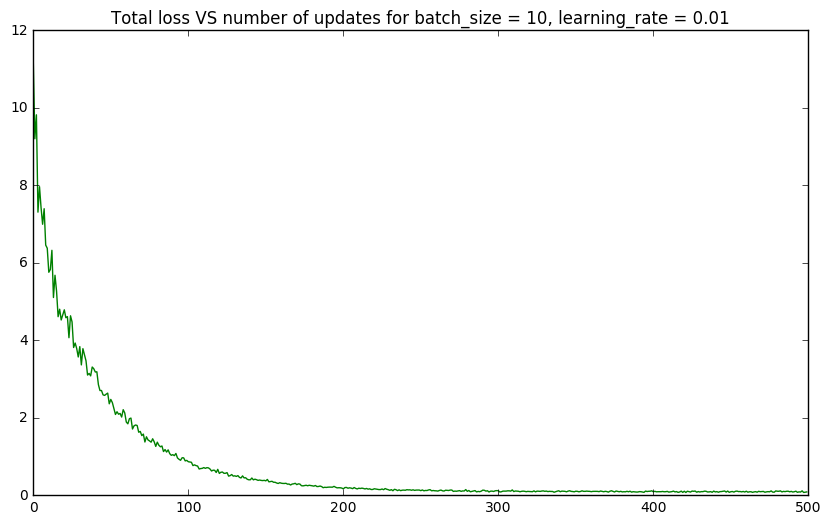

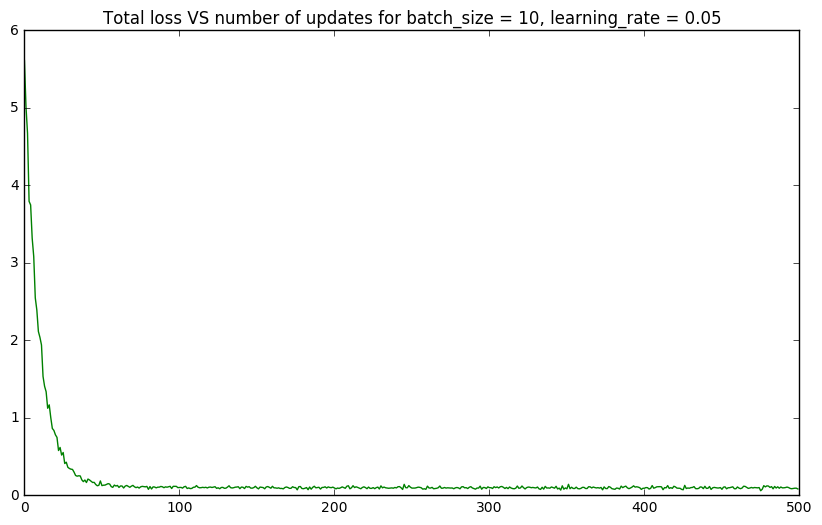

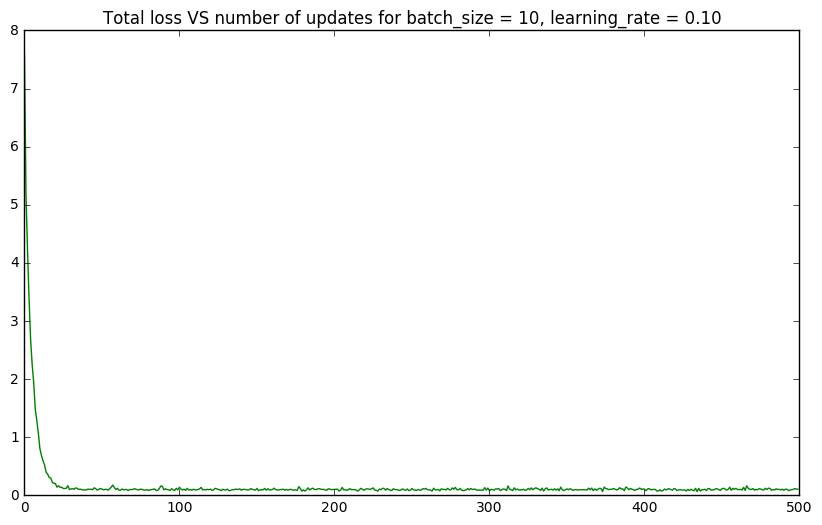

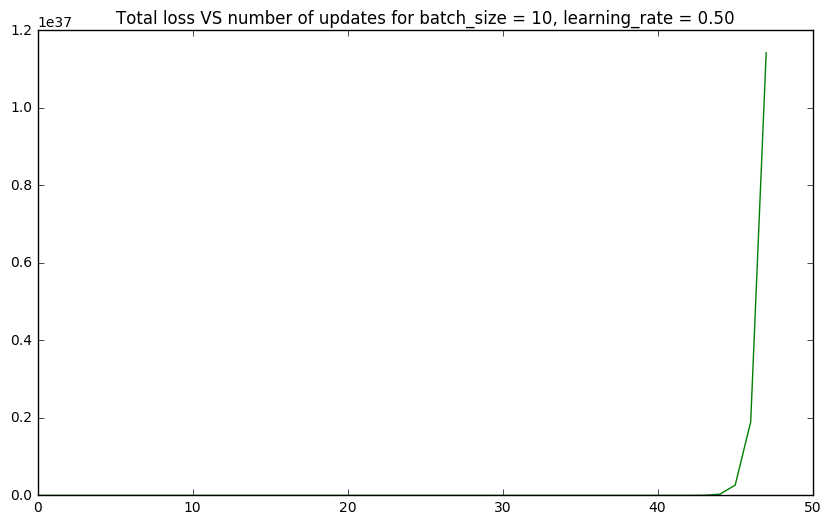

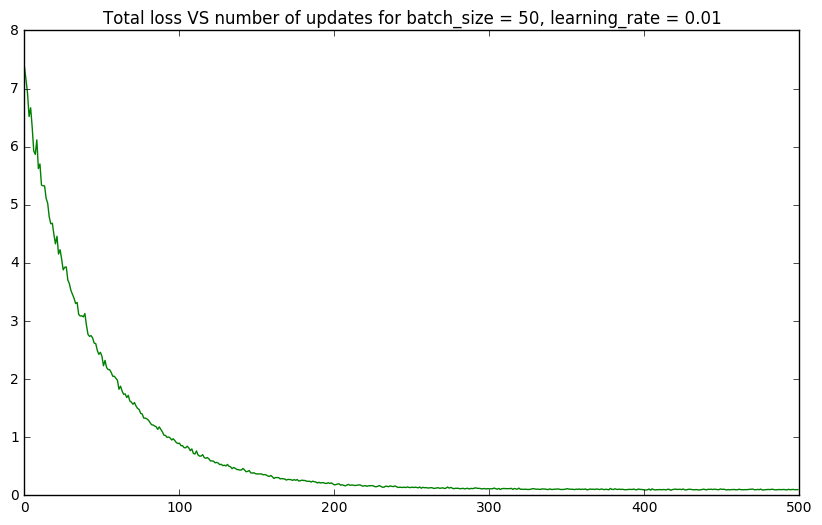

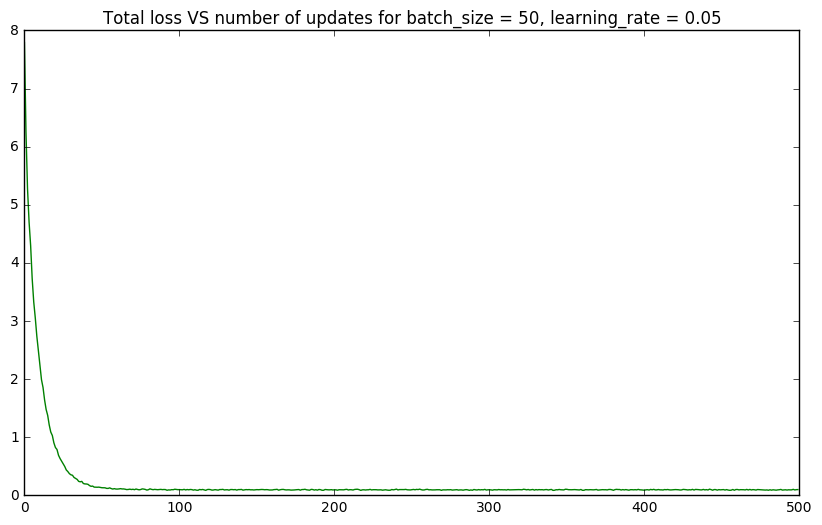

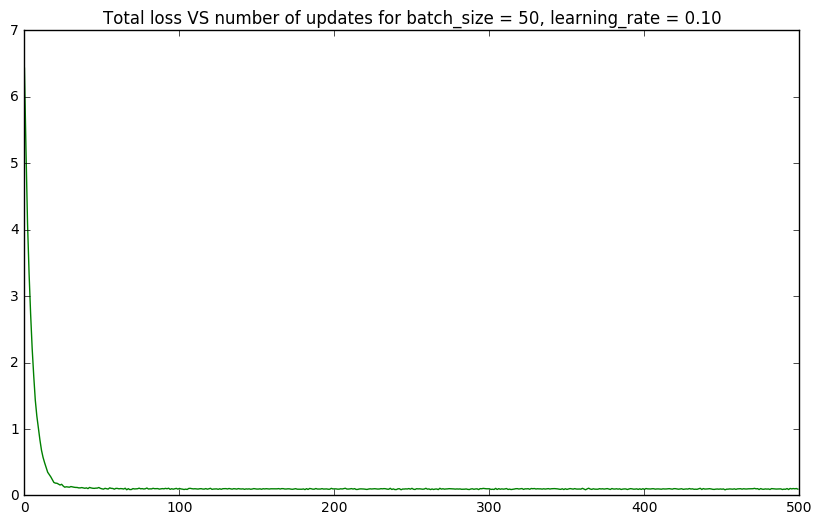

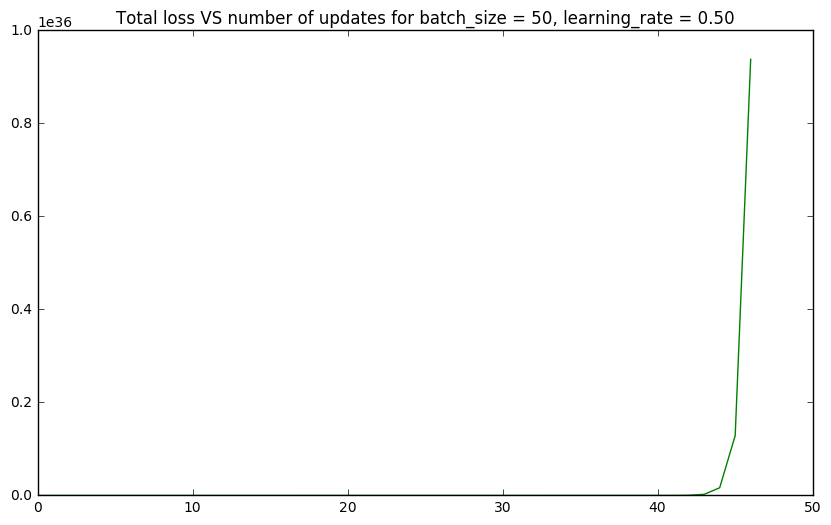

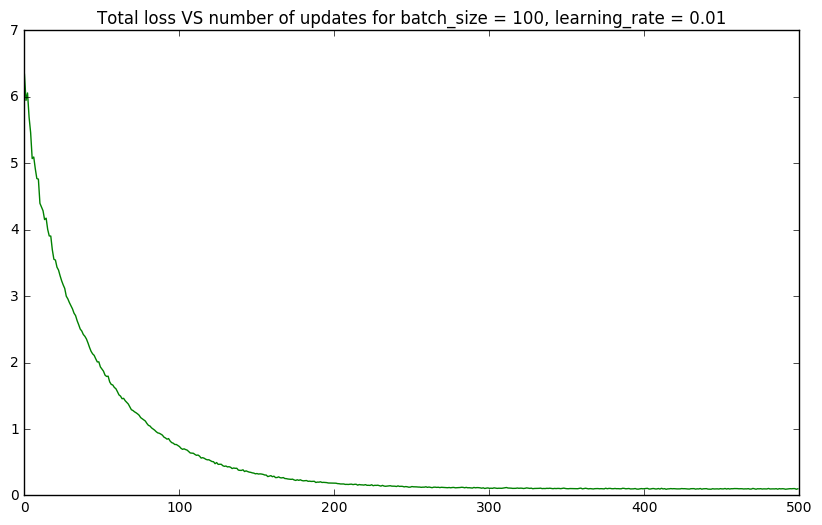

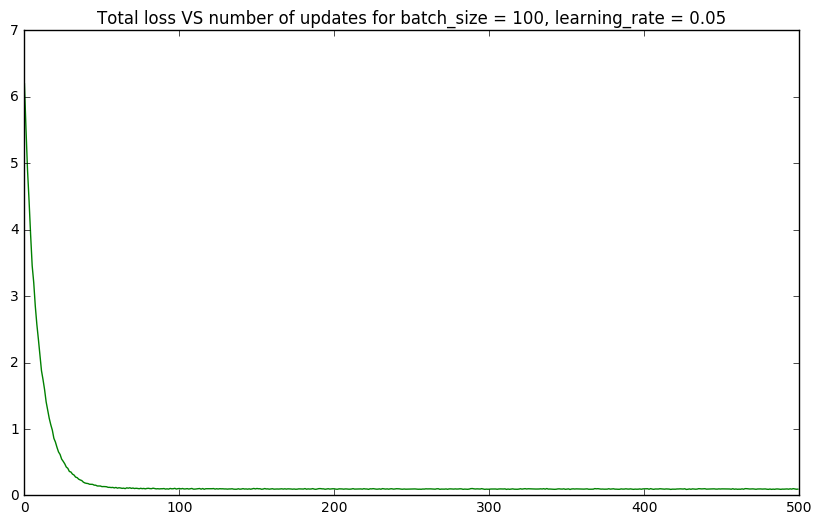

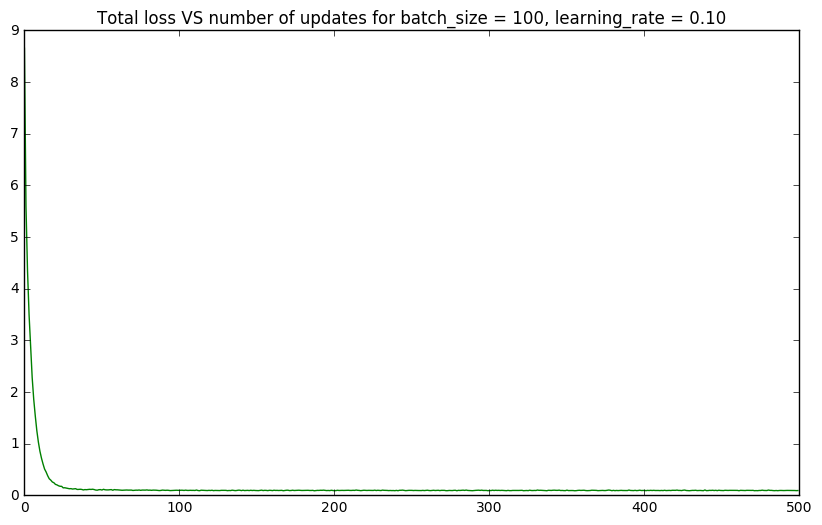

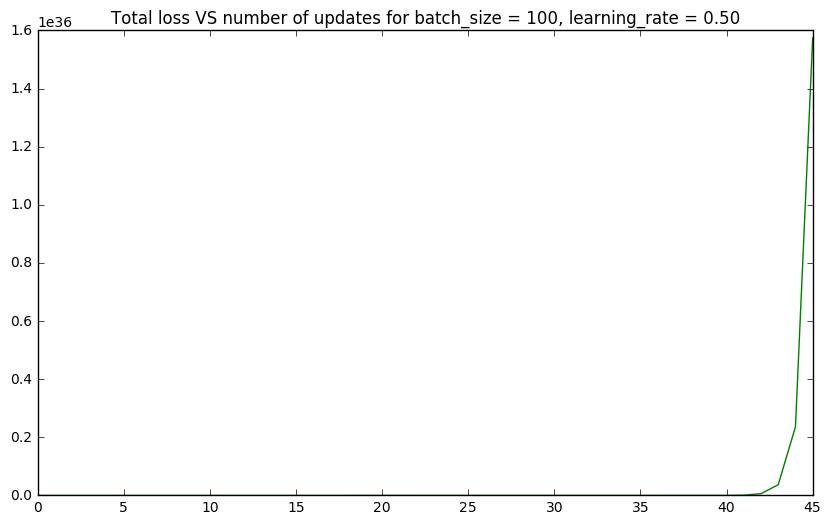

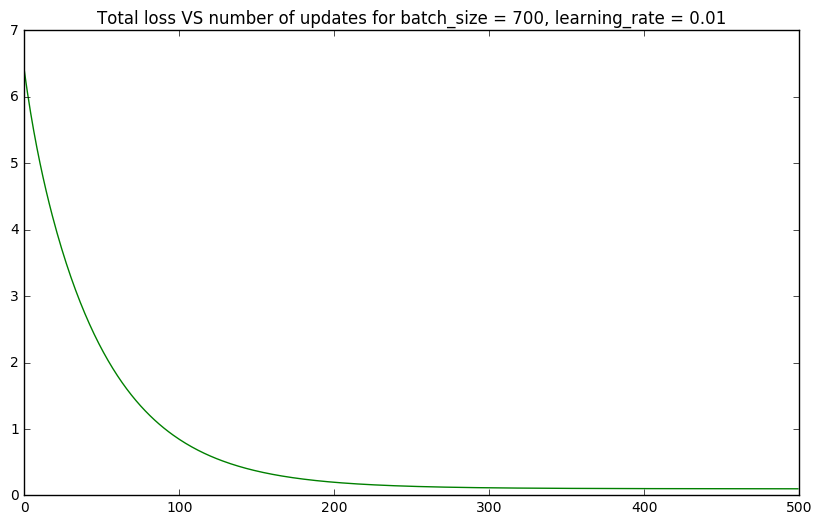

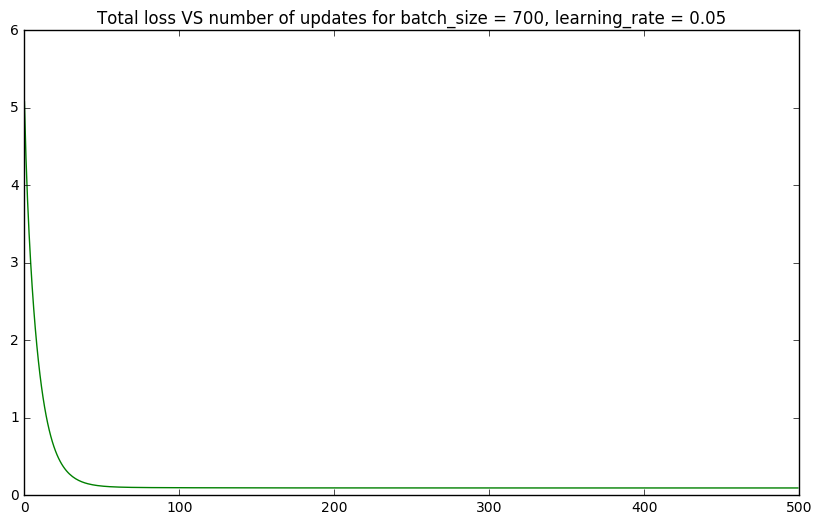

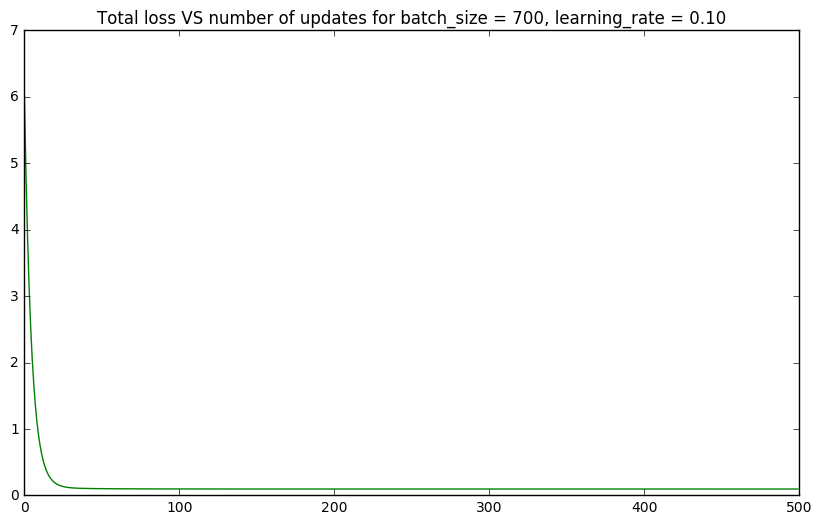

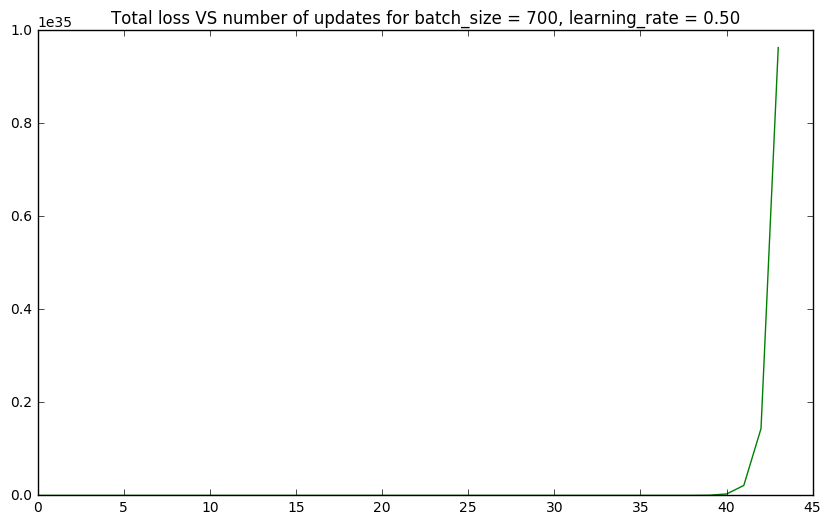

In [159]:
#2.2 fix decay_rate = 1 and tune learning_rate and batch_size
decay_rate = 1
batch_size_list = [10,50,100,700]
learning_rate_list = [0.01, 0.05, 0.1, 0.5]
for batch_size in batch_size_list:
    for learning_rate in learning_rate_list: 
        W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
        init = tf.global_variables_initializer()
        sess = tf.InteractiveSession()
        sess.run(init)
        loss_recorder = np.array([])
        for itr in range(500):
            batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
            loss, _ = sess.run([error, train], feed_dict={X: batch_xs, y_target: batch_ys})
            loss_recorder = np.append(loss_recorder, loss)
        plt.plot(np.arange(500), loss_recorder, 'g')
        #plt.axis([0,2000, 0, 2])
        plt.title("Total loss VS number of updates for batch_size = %d, learning_rate = %0.2f"%(batch_size, learning_rate))
        plt.show()

<h2>Conclusion</h2>
<p>In this problem we try different batch size and tune the learning rate respectly. We obeserve that setting learning rate 0.1 for all different batch size obtains the best convergence time overall. And we found that batch size has linear relation with training time. Considering the trade off between training time and randomization, we think batch size 50 is a good choice.

<h2>Problem 2.2.3 Generalization</h2>

Best accuracy in valid set is: 0.94, decay_rate is: 0.00


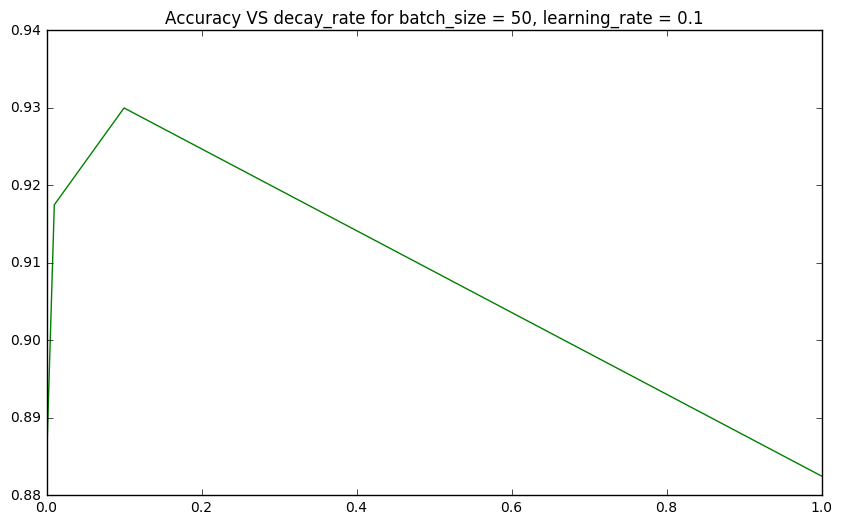

In [163]:
#2.3 fix batch_size = 50 and learning_rate = 0.1 and tune decay_rate
decay_rate_list = [0., 0.0001, 0.001, 0.01, 0.1, 1.]
batch_size = 50
learning_rate = 0.1
best_decay_rate = 0
best_acc = 0
test_acc_recorder = np.array([])
for decay_rate in decay_rate_list:
    W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
    correct_prediction = tf.equal(y_target, (tf.sign(y_predicted - 0.5) + 1)/2)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    for itr in range(500):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        sess.run(train, feed_dict={X: batch_xs, y_target: batch_ys})
    # use valid data set accuracy to tune decay rate
    cur_acc = sess.run(accuracy, feed_dict={X: validData, y_target: validTarget})
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_decay_rate = decay_rate
    # use test set to test accuracy
    test_acc_recorder = np.append(test_acc_recorder, sess.run(accuracy, \
                                                              feed_dict={X: testData, y_target: testTarget}))
print("Best accuracy in valid set is: %0.2f, decay_rate is: %0.2f"%(best_acc, best_decay_rate))
plt.plot(decay_rate_list, test_acc_recorder, 'g')
#plt.axis([0,2000, 0, 2])
plt.title("Accuracy VS decay_rate for batch_size = 50, learning_rate = 0.1")
plt.show()

<h2>Conclusion</h2>
<p> From the experiment, we found that the best accuracy in valid set is 0.94 when the decay rate is 0. Although decay rate 0 obtains good accuracy in valid set, it performs bad in test set with accuracy less than 90%. It encounts overfitting problem when we do not assign any regularization. However, when decay rate is set to 1, we can see its accuracy in test set also decreases dramatically. It is a problem of under fitting. The best decay rate is about 0.1 which obtains best accuracy in test set about 93%. The reason why we use validation set to tune hyper-parameter is to make sure we do not overfit the model. If we use training set to tune hyper-parameter, the weight will be adjusted to minimize the error. However, we cannot test if the model is general enough for some data set that is not used for training. Validation set is such a data set for testing if the training is overfit. If the accuracy in training set is increasing, but the accuracy in validation set remains the set, we know it might be overfiting.